100%|██████████| 12/12 [02:21<00:00, 11.83s/it]


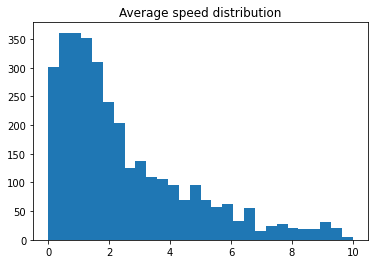

q25 0.9609371552555374 q50 2.6938087643486037 q75 4.42668037344167



In [23]:
# get the average velocity from the ground truth data

import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import pandas as pd
import numpy as np

SIMDATA_PATH="attack_data/sim_data/mules/"
GTDATA_PATH ="attack_data/ground_truth/"

SMOLDATA_PATH = "../smol_attacks/smol_sim/mules/"
SMOLGTDATA_PATH = "../smol_attacks/smol_truth/"

def average_velocity_from_trace(trace_files, limit=10000000, downsample=1):
    
    velocities = []
    for trace_file in tqdm(trace_files, position=0, leave=True):
        
        # import file
        gateway_df = pd.read_csv(trace_file)

        # down sample if needed
        gateway_df_smol = gateway_df[0:limit:downsample]
        gateway_df_smol.head()

        # filter to adjadent gateways with a time difference larger than 3 seconds
    #     diff_gateway_df = gateway_df_smol.diff()

    #     print(gateway_df_smol)

    #     backbone_gateway_df = gateway_df_smol[diff_gateway_df['norm_secs (secs)'] > 1]
    #     backbone_gateway_df.head()

        # import the ground truth gateway location file
        gateway_positions_df = pd.read_csv(SMOLGTDATA_PATH + 'sensors.csv')

        if gateway_df_smol.shape[0] <= 1:
            print('  only', gateway_df_smol.shape[0], 'points, aborting')
            return8

        for i in range(1, gateway_df_smol.shape[0]):

            # source gateway info
            src_gateway_id = int(gateway_df_smol.iloc[i-1]['sensor ID'])
            src_time_s     = float(gateway_df_smol.iloc[i-1]['norm_secs (secs)'])

            src_gateway_x  = gateway_positions_df.iloc[src_gateway_id]['x (m)']
            src_gateway_y  = gateway_positions_df.iloc[src_gateway_id]['y (m)']

            # destination gateway info
            dst_gateway_id = int(gateway_df_smol.iloc[i]['sensor ID'])
            dst_time_s     = float(gateway_df_smol.iloc[i]['norm_secs (secs)'])

            dst_gateway_x  = gateway_positions_df.iloc[dst_gateway_id]['x (m)']
            dst_gateway_y  = gateway_positions_df.iloc[dst_gateway_id]['y (m)']

            # skip if we're just looking at the same gateway
            if src_gateway_id == dst_gateway_id:
                continue

            # calculate distance and time between gateways
            distance = math.sqrt((src_gateway_x - dst_gateway_x)**2 + (src_gateway_y - dst_gateway_y)**2)
            time_diff = dst_time_s - src_time_s

            # skip if (almost) no time has passed
            if time_diff < 1:
                continue

            velocities.append(
                distance / time_diff
            )

            #print('src gateway {:2} -> dst gateway {:2} in {:7.2f} s: {:8.2f} m/s estimated velocity over {:8.2f} m'.format(
            #    src_gateway_id, dst_gateway_id, time_diff, distance / time_diff, distance))

    _ = plt.hist(velocities, range=[0, 10], bins='auto')
    plt.title('Average speed distribution')
    plt.show()

    q75, q25 = np.percentile(velocities, [75 ,25])
    iqr = q75 - q25

    print('q25', q25, 'q50', q25 + iqr/2, 'q75', q75)
    print()
    
    
# average_velocity_from_trace(SIMDATA_PATH + "104.csv")
# average_velocity_from_trace(SIMDATA_PATH + "135.csv")

mule_ids = ['007', '011', '022', '024', '025', '038', '052', '062', '071', '085', '126', '167']
#mule_ids = ['007']

average_velocity_from_trace([SMOLDATA_PATH+m+'.csv' for m in mule_ids])
